Project overview:

- Dataset used: https://www.kaggle.com/gobsan/st-george-or-not
- Dataset description: binary classification of ~6000 pics with St. George.

This NB attempts to classify a given dataset with Saint George using Pytorch and a pretrained resnet50 model. 
No extra images were added to the dataset.

This is what was done:

1. Prep work included using Pandas for path and label collection of all data.
2. The data was split into train, valid and test datasets.
3. Some minor augmentations added to the data.
4. The model was 1st trained with all but the last layer frozen for a couple of epochs, then all params were unfrozen and the whole model trained again.
5. tta was used on test dataset.

The model shows signs of overfitting the train set, but valid and, most importantly, test set error rates are good indicators of the model working properly.

# data preparation

In [1]:
# this is needed for tta at the end
# !pip install ttach

In [2]:
# imports
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import time
from PIL import Image
import ttach as tta

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

import albumentations as A
import albumentations.pytorch
from sklearn.model_selection import train_test_split

In [3]:
# setting seed
torch.manual_seed(0)
np.random.seed(0)

In [4]:
# setting device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# HYPERPARAMS HERE

# params
lr = 3e-3
momentum = 0.9
weight_decay = 3e-3

# transforms
presize = 256
crop = 256

# batch size
batch_size = 32

# n_epochs
frozen = 1
unfrozen = 1

In [7]:
# data preparation
# path = '../input/st-george-or-not/data' # for kaggle
path = 'data' # for local use
path_g = os.path.join(path, 'resized_smallest_g')
path_ng = os.path.join(path, 'resized_smallest_ng')

data_g = os.listdir(path_g)
data_ng = os.listdir(path_ng)

df_g = pd.DataFrame({'fnames': [os.path.join(path_g, i) for i in data_g], 'label':1})
df_ng = pd.DataFrame({'fnames': [os.path.join(path_ng, i) for i in data_ng], 'label':0})

df = pd.concat([df_g, df_ng], ignore_index=True)

print('df shape before re', df.shape)
df = df[df.fnames.str.contains('.*\.jpg$')]
print('df shape after re', df.shape)

df = df.sample(frac=1).reset_index(drop=True)

# df.head(10)

df shape before re (504, 2)
df shape after re (504, 2)


# train_test_split

In [8]:
train_df = df.iloc[:380, :].reset_index(drop=True)
valid_df = df.iloc[380:440, :].reset_index(drop=True)
test_df = df.iloc[440:, :].reset_index(drop=True)

train_df.shape, valid_df.shape, test_df.shape

((380, 2), (60, 2), (64, 2))

# transforms

In [9]:
# albumentations transforms

train_transforms = A.Compose([
    A.SmallestMaxSize(presize),
    A.RandomCrop(crop, crop),
    A.Normalize(),
    A.HorizontalFlip(),
    A.Rotate(limit=30),
    albumentations.pytorch.ToTensorV2()
    ])

valid_transforms = A.Compose([
    A.SmallestMaxSize(presize),
    A.CenterCrop(crop, crop),
    A.Normalize(),
    A.HorizontalFlip(),
    albumentations.pytorch.ToTensorV2()
    ])

test_transforms = A.Compose([
    A.SmallestMaxSize(presize),
    A.CenterCrop(crop, crop),
    A.Normalize(),
    albumentations.pytorch.ToTensorV2()
    ])

# defining dataset class

In [10]:
class dataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df=df
        self.transforms=transforms
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        image = Image.open(self.df.fnames[index]).convert('RGB')
        image = np.array(image)
        
        label = torch.tensor(self.df.label[index]).long()
        
        if self.transforms:
            augmentations = self.transforms(image=image)
            image = augmentations['image']
            
        return image, label

In [11]:
train_dataset = dataset(train_df, transforms=train_transforms)
valid_dataset = dataset(valid_df, transforms=valid_transforms)
test_dataset = dataset(test_df, transforms=test_transforms)

# check if datasets looks good
print(f'dataset len: {len(train_dataset)}, {len(valid_dataset)}')
print(f'image dtype: {train_dataset[44][0].dtype}, \nlabel dtype: {train_dataset[44][1].dtype}')
print(f'dataset image shape: {train_dataset[44][0].shape}')
# train_dataset[44]

dataset len: 380, 60
image dtype: torch.float32, 
label dtype: torch.int64
dataset image shape: torch.Size([3, 256, 256])


# dataloader

In [15]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f'train loader steps: {len(train_loader)}')

train loader steps: 12


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


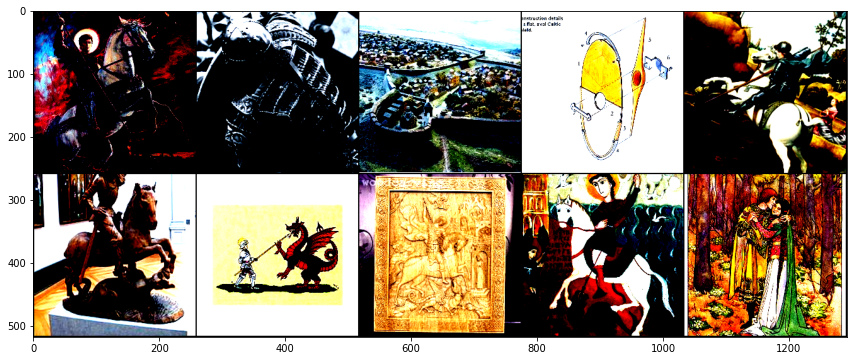

In [16]:
# displayig the data
batch_tensor = next(iter(train_loader))[0][:10,...]
grid_img = torchvision.utils.make_grid(batch_tensor, nrow=5)
# grid_img.shape
plt.figure(figsize=(16,6))
plt.imshow(grid_img.permute(1, 2, 0)); # uncomment to show

In [17]:
# check if dataloaders are ok
print(f'dataloader test: {next(iter(train_loader))[0].shape}, {next(iter(valid_loader))[0].shape}')

dataloader test: torch.Size([32, 3, 256, 256]), torch.Size([32, 3, 256, 256])


# load model, freeze layers

In [18]:
model = torchvision.models.resnext50_32x4d(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to C:\Users\Oleg/.cache\torch\hub\checkpoints\resnext50_32x4d-7cdf4587.pth
100.0%


# criterion, optimizer and lr_scheduler

In [19]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

# train model

In [20]:
def train_model(n_epochs=1,
                model=model,
                train_loader=train_loader,
                valid_loader=valid_loader,
                criterion=criterion,
                optimizer=optimizer,
                lr_scheduler=lr_scheduler):
    
    total_time = time.time()
    print(f'================')
    print(f'started training...')
    
    for epoch in range(n_epochs):
        
        model.train()
        t0 = time.time()
        epoch_loss = 0

        for batch, (images, labels) in enumerate(train_loader):

            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            epoch_loss += loss

            loss.backward()
            optimizer.step()
        
        train_avg_epoch_loss = round(float(epoch_loss/len(train_loader)), 4)
        valid_avg_epoch_loss, valid_epoch_accuracy = test_model(model, valid_loader)
        epoch_time = round(time.time() - t0)
        
        lr_scheduler.step()
        
        print(f'epoch: [{epoch+1}/{n_epochs}] | train loss: {train_avg_epoch_loss} | valid loss: {valid_avg_epoch_loss} | valid acc: {valid_epoch_accuracy} | time: {epoch_time//60:.0f}m {epoch_time%60:.0f}s')
    
    return model

# test model

In [21]:
def test_model(model, valid_loader):
    
    model.eval()
    correct_on_epoch = 0
    total_num_images = 0
    epoch_loss = 0
    
    with torch.no_grad():
        
        for batch, (images, labels) in enumerate(valid_loader):
            
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            total_num_images += labels.size(0)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            loss = criterion(outputs, labels)
            epoch_loss += loss

            correct_on_epoch += (preds==labels).sum().item()
    
    valid_epoch_accuracy = round((correct_on_epoch/total_num_images), 4)
    valid_avg_epoch_loss = round(float(epoch_loss/len(valid_loader)), 4)
    
    return valid_avg_epoch_loss, valid_epoch_accuracy

# unfreeze

In [22]:
def unfreeze(model=model):
    for param in model.parameters():
        param.requires_grad = True
    return model

# training model

In [23]:
start_time = time.time()

train_model(frozen)
unfreeze()
train_model(unfrozen)

total_time = time.time() - start_time
print(f'train time: {total_time//60:.0f}m {total_time%60:.0f}s')

started training...
epoch: [1/1] | train loss: 0.6604 | valid loss: 0.7993 | valid acc: 0.45 | time: 2m 24s
started training...
epoch: [1/1] | train loss: 0.5464 | valid loss: 0.6324 | valid acc: 0.5667 | time: 5m 46s
train time: 8m 10s


# saving model

In [24]:
# checkpoint = {'model': model,
#               'state_dict': model.state_dict()}

# torch.save(checkpoint, 'checkpoint_new.pth')

# test model no tta

In [25]:
_, test_acc = test_model(model, test_loader)
print(f'test set acc: {test_acc}')

test set acc: 0.7188


# tta

In [27]:
start_time = time.time()

tta_crop = int(presize*0.9)
tta_model = tta.ClassificationTTAWrapper(model, tta.aliases.five_crop_transform(tta_crop, tta_crop))

tta_transforms = A.Compose([
    A.SmallestMaxSize(presize),
    A.Normalize(),
    albumentations.pytorch.ToTensorV2()
])

tta_dataset = dataset(test_df, transforms=tta_transforms)
tta_loader = DataLoader(tta_dataset, batch_size=1, shuffle=False, num_workers=0)

_, tta_acc = test_model(tta_model, tta_loader)

print(f'TTA acc: {tta_acc}')

total_time = time.time() - start_time
print(f'TTA time: {total_time//60:.0f}m {total_time%60:.0f}s')

TTA acc: 0.7344
TTA time: 2m 15s
